In [1]:
# Import libs

from moviepy.editor import VideoFileClip
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

from keras.models import Model
from keras.layers import Conv2D, MaxPooling3D, Flatten, Dense, Reshape, BatchNormalization, Attention, Input, UpSampling3D

from keras.callbacks import EarlyStopping

2024-03-18 17:49:24.796089: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-03-18 17:49:25.241447: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-03-18 17:49:25.247379: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-03-18 17:49:27.199688: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
# Split cartoon fragment on frames
# In case not to overfull RAM i sqeeze image in 8 times and take each 6'th frame 

clip = VideoFileClip("video.mp4")
img_w = 640 // 8
img_h = 480 // 8

frames = []
for idx, frame in enumerate(clip.iter_frames(fps = clip.fps // 6), start = 1):
    frame = Image.fromarray(frame)
    frame = frame.resize((img_w, img_h))
    frame = np.array(frame)
    frames.append(frame)


len(frames)


2074

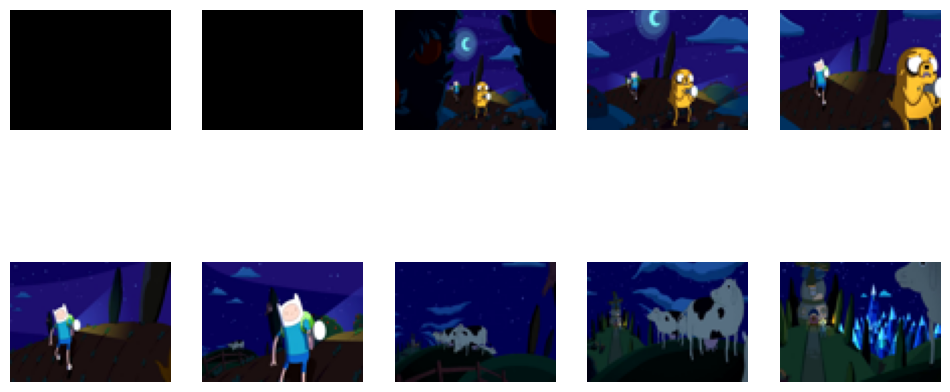

In [ ]:
# Show first 10 fraems

fig, axes = plt.subplots(2, 5, figsize = (12, 6))
for i, ax in enumerate(axes.ravel()):
    ax.imshow(frames[i])
    ax.axis("off")

plt.show()

In [3]:
# Normalize them

frames = np.array(frames) / 255.0

In [4]:
# Make frame sequence in case to predict next frame based on prev 16

X_sequence = []
y = []

for i, img in enumerate(frames):
    if i < len(frames) - 1:
        y.append(frames[i + 1])

        sequence = []
        for j in range(16):
            if i - j >= 0:
                sequence.append(frames[i - j])
            else:
                # In case we get first 15 frames who has no 16 prev frames simple append 0 frame (black screen)
                sequence.append(frames[0])

        X_sequence.append(sequence)

frames = None

In [5]:
# Split data

X_sequence_train, X_sequence_test, y_train, y_test = train_test_split(X_sequence, y, train_size = 0.8, random_state = 1212)

X_sequence = None
y = None

X_sequence_train = np.array(X_sequence_train)
X_sequence_test = np.array(X_sequence_test)
y_train = np.array(y_train)
y_test = np.array(y_test)

In [ ]:
# Create non transformer neural network

inputs = Input(shape = (16, img_h, img_w, 3))

x = Conv2D(32, (3, 3), activation = 'relu', padding = 'same')(inputs)
x = MaxPooling3D((1, 2, 2))(x)
x = BatchNormalization()(x)

x = Conv2D(64, (3, 3), activation = 'relu', padding = 'same')(x)
x = MaxPooling3D((1, 2, 2))(x)
x = BatchNormalization()(x)

x = Conv2D(64, (3, 3), activation = 'relu', padding = 'same')(x)
x = MaxPooling3D((1, 2, 2))(x)
x = BatchNormalization()(x)

x = Flatten()(x)
x = Dense(1024, activation = 'relu')(x)
x = Dense(img_h * img_w * 3, activation = 'sigmoid')(x)

x = Reshape((img_h, img_w, 3))(x)

model = Model(inputs = inputs, outputs = x)

model.compile(optimizer = 'adam', loss = 'mse')

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 16, 60, 80, 32)    896       
                                                                 
 max_pooling3d (MaxPooling3  (None, 16, 30, 40, 32)    0         
 D)                                                              
                                                                 
 batch_normalization (Batch  (None, 16, 30, 40, 32)    128       
 Normalization)                                                  
                                                                 
 conv2d_1 (Conv2D)           (None, 16, 30, 40, 64)    18496     
                                                                 
 max_pooling3d_1 (MaxPoolin  (None, 16, 15, 20, 64)    0         
 g3D)                                                            
                                                        

In [6]:
early_stopping = EarlyStopping(monitor = 'val_loss',
                               patience = 13,
                               restore_best_weights = True)

In [ ]:
history = model.fit(
    X_sequence_train,
    y_train,
    epochs = 100,
    batch_size = 8,
    validation_data = (X_sequence_test, y_test),
    callbacks = [early_stopping]
)

Epoch 1/100
208/208 [==============================] - 21s 76ms/step - loss: 0.0698 - val_loss: 0.0830
Epoch 2/100
208/208 [==============================] - 14s 67ms/step - loss: 0.0531 - val_loss: 0.0493
Epoch 3/100
208/208 [==============================] - 13s 63ms/step - loss: 0.0474 - val_loss: 0.0560
Epoch 4/100
208/208 [==============================] - 14s 67ms/step - loss: 0.0443 - val_loss: 0.0450
Epoch 5/100
208/208 [==============================] - 14s 67ms/step - loss: 0.0429 - val_loss: 0.0520
Epoch 6/100
208/208 [==============================] - 14s 66ms/step - loss: 0.0414 - val_loss: 0.0444
Epoch 7/100
208/208 [==============================] - 14s 65ms/step - loss: 0.0402 - val_loss: 0.0429
Epoch 8/100
208/208 [==============================] - 13s 65ms/step - loss: 0.0390 - val_loss: 0.0434
Epoch 9/100
208/208 [==============================] - 14s 66ms/step - loss: 0.0386 - val_loss: 0.0438
Epoch 10/100
208/208 [==============================] - 15s 74ms/step - l

1/1 [==============================] - 0s 421ms/step


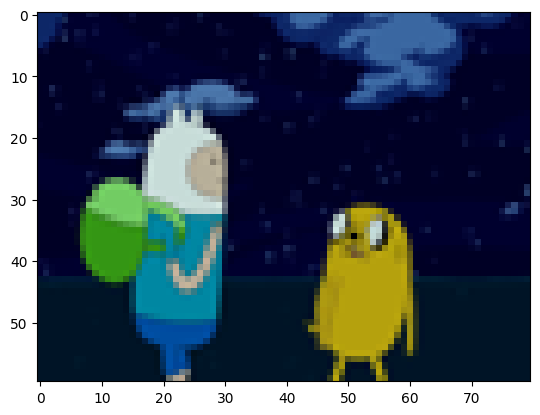

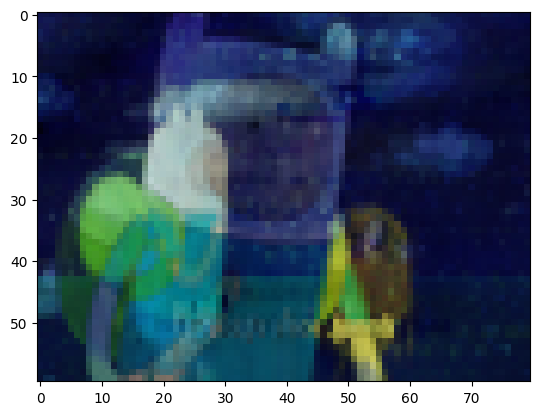

In [ ]:
# Show 1 next frame

next_frame = model.predict(np.expand_dims(X_sequence_test[10], axis = 0))

plt.imshow(X_sequence_test[10, 0])
plt.show()

plt.imshow(next_frame[0])
plt.show()

1/1 [==============================] - 0s 20ms/step


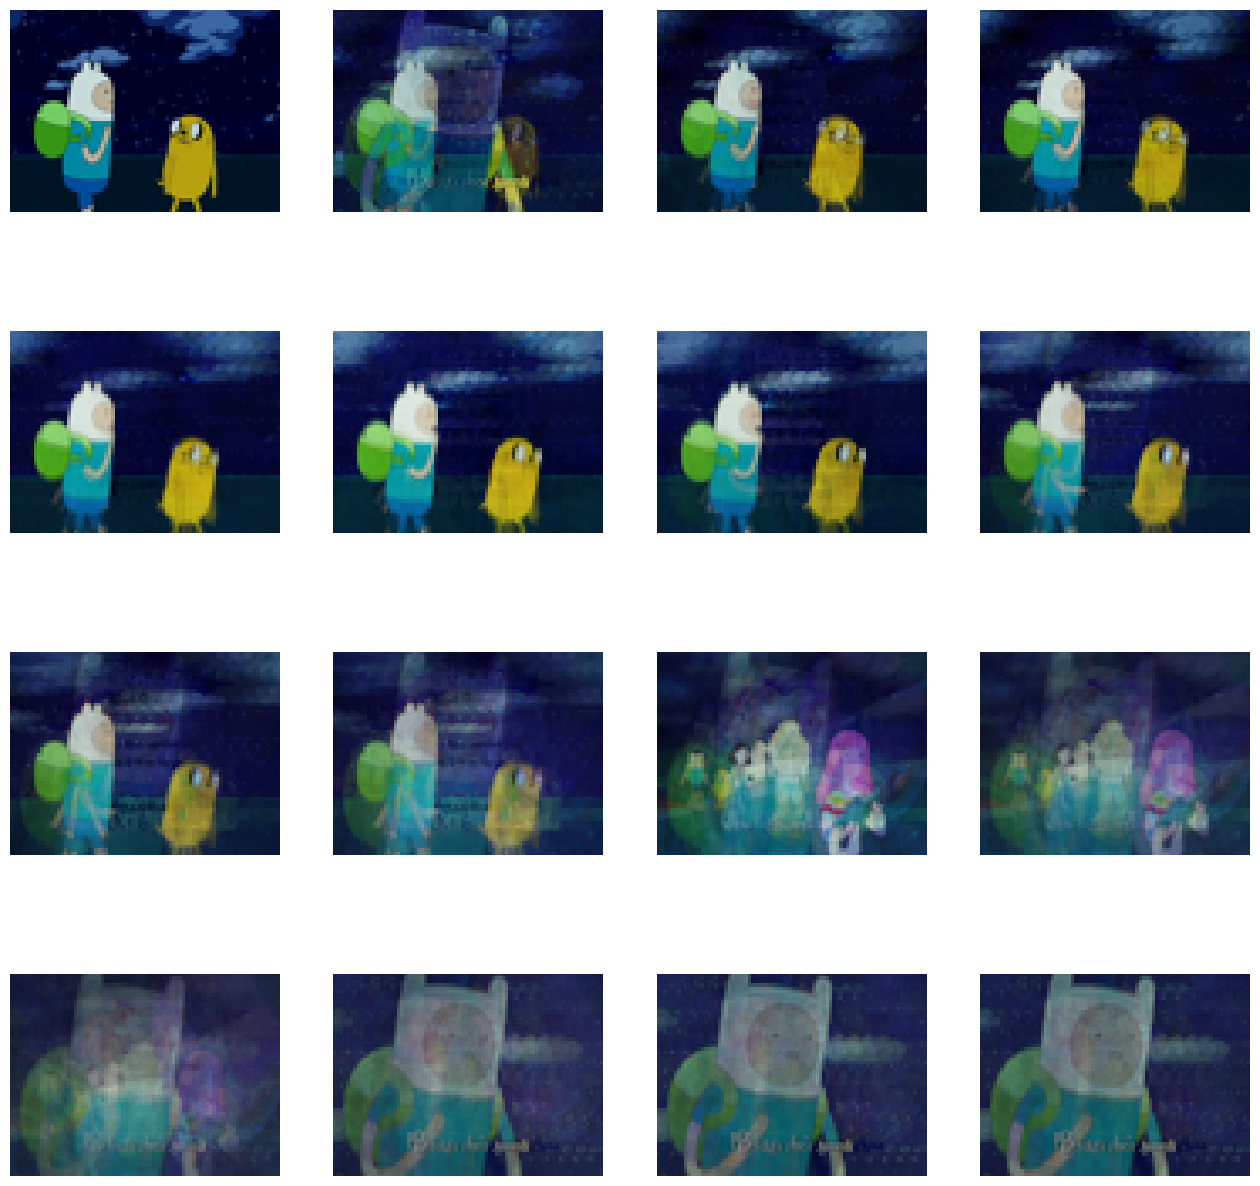

In [ ]:
# Show 16 next frames

to_show = 10
sequence = X_sequence_test[to_show]

series = [X_sequence_test[to_show, 0]]

for i in range(16):
    next_frame = model.predict(np.expand_dims(sequence, axis = 0))

    sequence = np.concatenate((sequence[1:, :, :, :], next_frame), axis = 0)
    frame = next_frame[0]
    series.append(frame)

fig, axes = plt.subplots(4, 4, figsize = (16, 16))

for i in range(4):
    for j in range(4):
        axes[i, j].imshow(series[i * 4 + j])
        axes[i, j].axis('off')

plt.show()


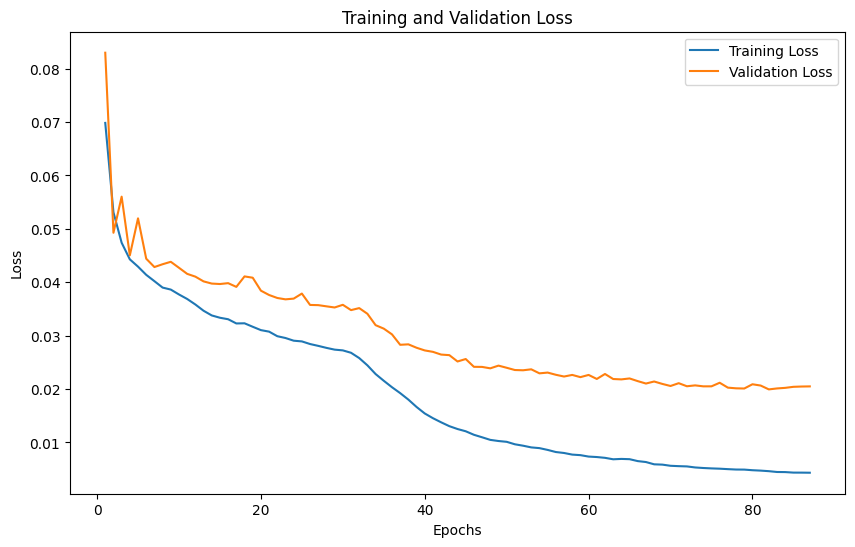

In [ ]:
# show training metric

train_loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize = (10, 6))
epochs = range(1, len(train_loss) + 1)
plt.plot(epochs, train_loss, label = 'Training Loss')
plt.plot(epochs, val_loss, label = 'Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [7]:
# Create trainsformer

inputs = Input(shape = (16, img_h, img_w, 3))

x_c1 = Conv2D(64, (3, 3), activation = 'relu', padding = 'same')(inputs)
x_c1 = MaxPooling3D((1, 2, 2))(x_c1)
x_c1 = BatchNormalization()(x_c1)

x_c2 = Conv2D(64, (3, 3), activation = 'relu', padding = 'same')(x_c1)
x_c2 = Attention()([x_c1, x_c2]) # Add Attention layer here
x_c2 = MaxPooling3D((1, 2, 2))(x_c2)
x_c2 = BatchNormalization()(x_c2)

x_c3 = Conv2D(64, (3, 3), activation = 'relu', padding = 'same')(x_c2)
x_c3 = Attention()([x_c2, x_c3]) # And here
x_c3 = MaxPooling3D((1, 2, 2))(x_c3)
x_c3 = BatchNormalization()(x_c3)

x = Flatten()(x_c3)
x = Dense(1024, activation = 'relu')(x)
x = Dense(img_h * img_w * 3, activation = 'sigmoid')(x)

x = Reshape((img_h, img_w, 3))(x)

model = Model(inputs = inputs, outputs = x)

model.compile(optimizer = 'adam', loss = 'mse')

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 16, 60, 80, 3)]      0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 16, 60, 80, 64)       1792      ['input_1[0][0]']             
                                                                                                  
 max_pooling3d (MaxPooling3  (None, 16, 30, 40, 64)       0         ['conv2d[0][0]']              
 D)                                                                                               
                                                                                                  
 batch_normalization (Batch  (None, 16, 30, 40, 64)       256       ['max_pooling3d[0][0]']   

In [8]:
history = model.fit(
    X_sequence_train,
    y_train,
    epochs = 100,
    batch_size = 8,
    validation_data = (X_sequence_test, y_test),
    callbacks = [early_stopping]
)

Epoch 1/100
208/208 [==============================] - 28s 106ms/step - loss: 0.0701 - val_loss: 0.0975
Epoch 2/100
208/208 [==============================] - 19s 92ms/step - loss: 0.0532 - val_loss: 0.0590
Epoch 3/100
208/208 [==============================] - 19s 93ms/step - loss: 0.0501 - val_loss: 0.0513
Epoch 4/100
208/208 [==============================] - 19s 90ms/step - loss: 0.0484 - val_loss: 0.0646
Epoch 5/100
208/208 [==============================] - 20s 98ms/step - loss: 0.0460 - val_loss: 0.0472
Epoch 6/100
208/208 [==============================] - 19s 90ms/step - loss: 0.0454 - val_loss: 0.0519
Epoch 7/100
208/208 [==============================] - 20s 94ms/step - loss: 0.0442 - val_loss: 0.0467
Epoch 8/100
208/208 [==============================] - 19s 90ms/step - loss: 0.0431 - val_loss: 0.0490
Epoch 9/100
208/208 [==============================] - 19s 90ms/step - loss: 0.0440 - val_loss: 0.0478
Epoch 10/100
208/208 [==============================] - 19s 90ms/step - 

1/1 [==============================] - 0s 343ms/step


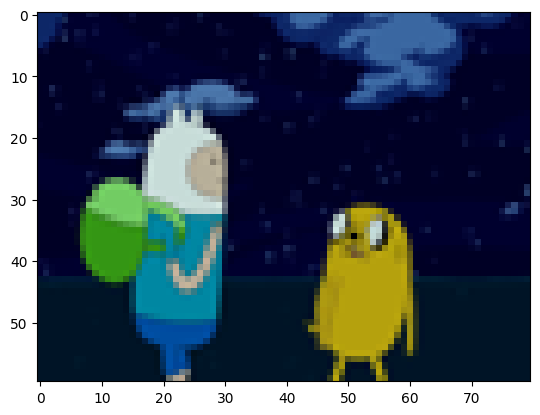

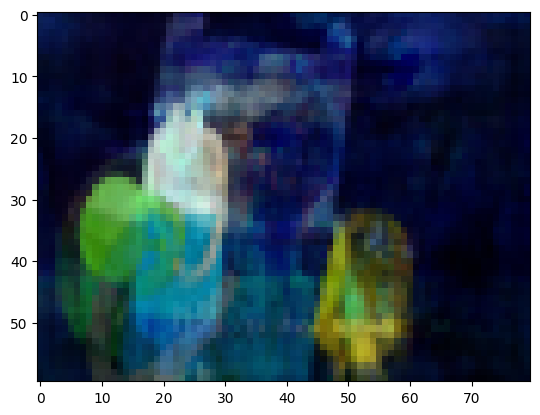

In [9]:
# Get worth metrics, but some how picture saturation better...

next_frame = model.predict(np.expand_dims(X_sequence_test[10], axis = 0))

plt.imshow(X_sequence_test[10, 0])
plt.show()

plt.imshow(next_frame[0])
plt.show()

1/1 [==============================] - 0s 19ms/step


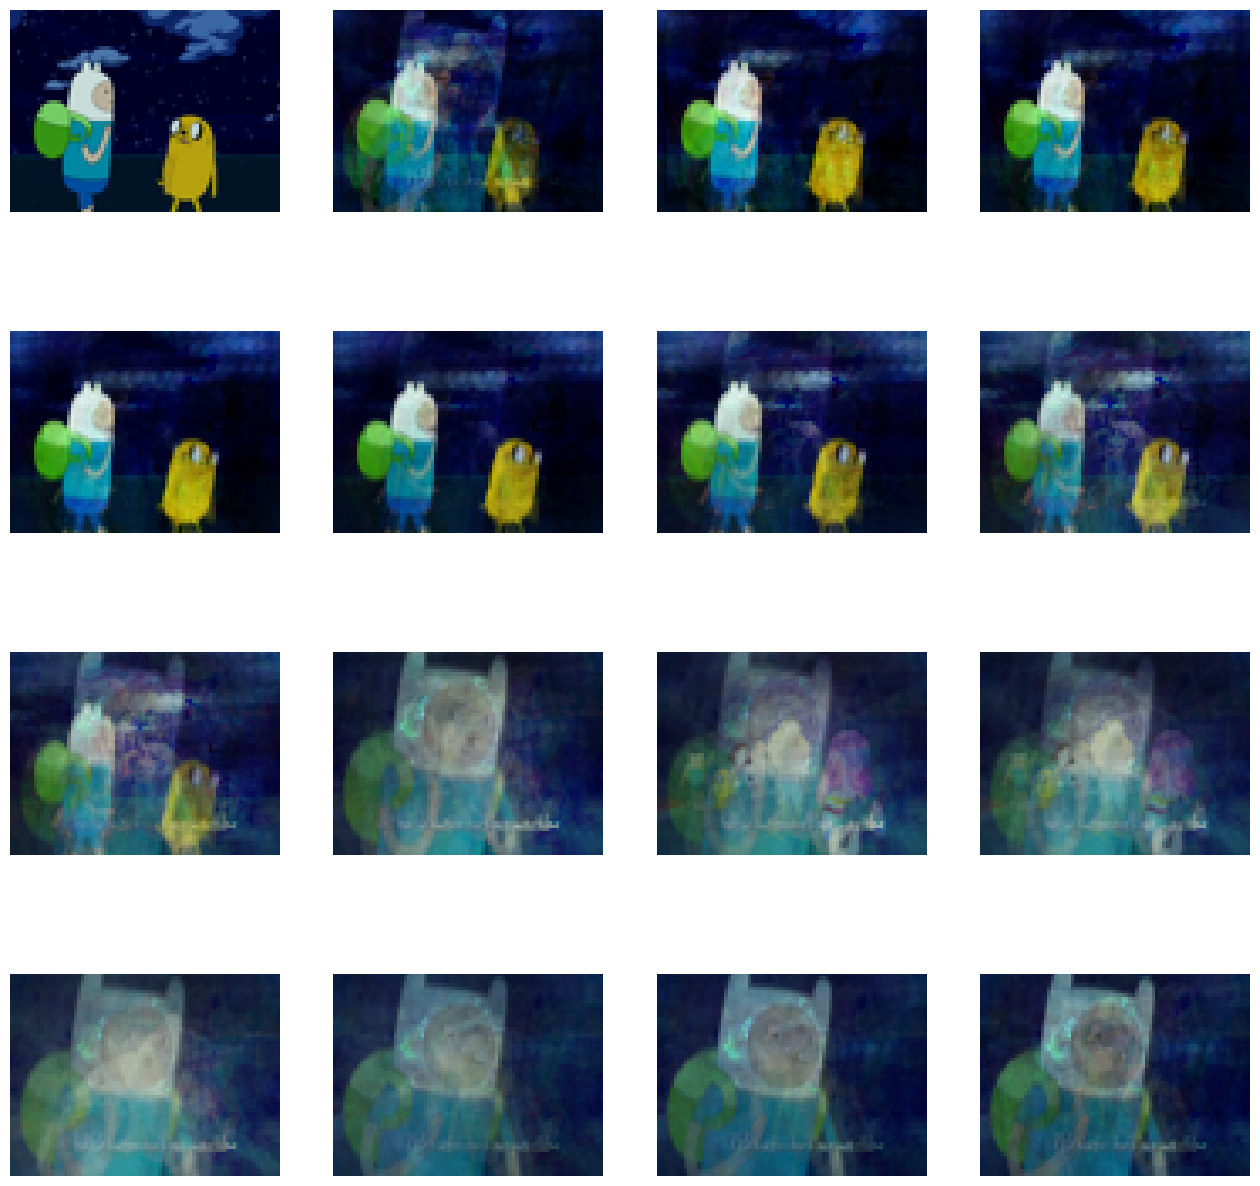

In [10]:
# Lrt's predict more frames

to_show = 10
sequence = X_sequence_test[to_show]

series = [X_sequence_test[to_show, 0]]

for i in range(16):
    next_frame = model.predict(np.expand_dims(sequence, axis = 0))

    sequence = np.concatenate((sequence[1:, :, :, :], next_frame), axis = 0)
    frame = next_frame[0]
    series.append(frame)

fig, axes = plt.subplots(4, 4, figsize = (16, 16))

for i in range(4):
    for j in range(4):
        axes[i, j].imshow(series[i * 4 + j])
        axes[i, j].axis('off')

plt.show()


1/1 [==============================] - 0s 30ms/step


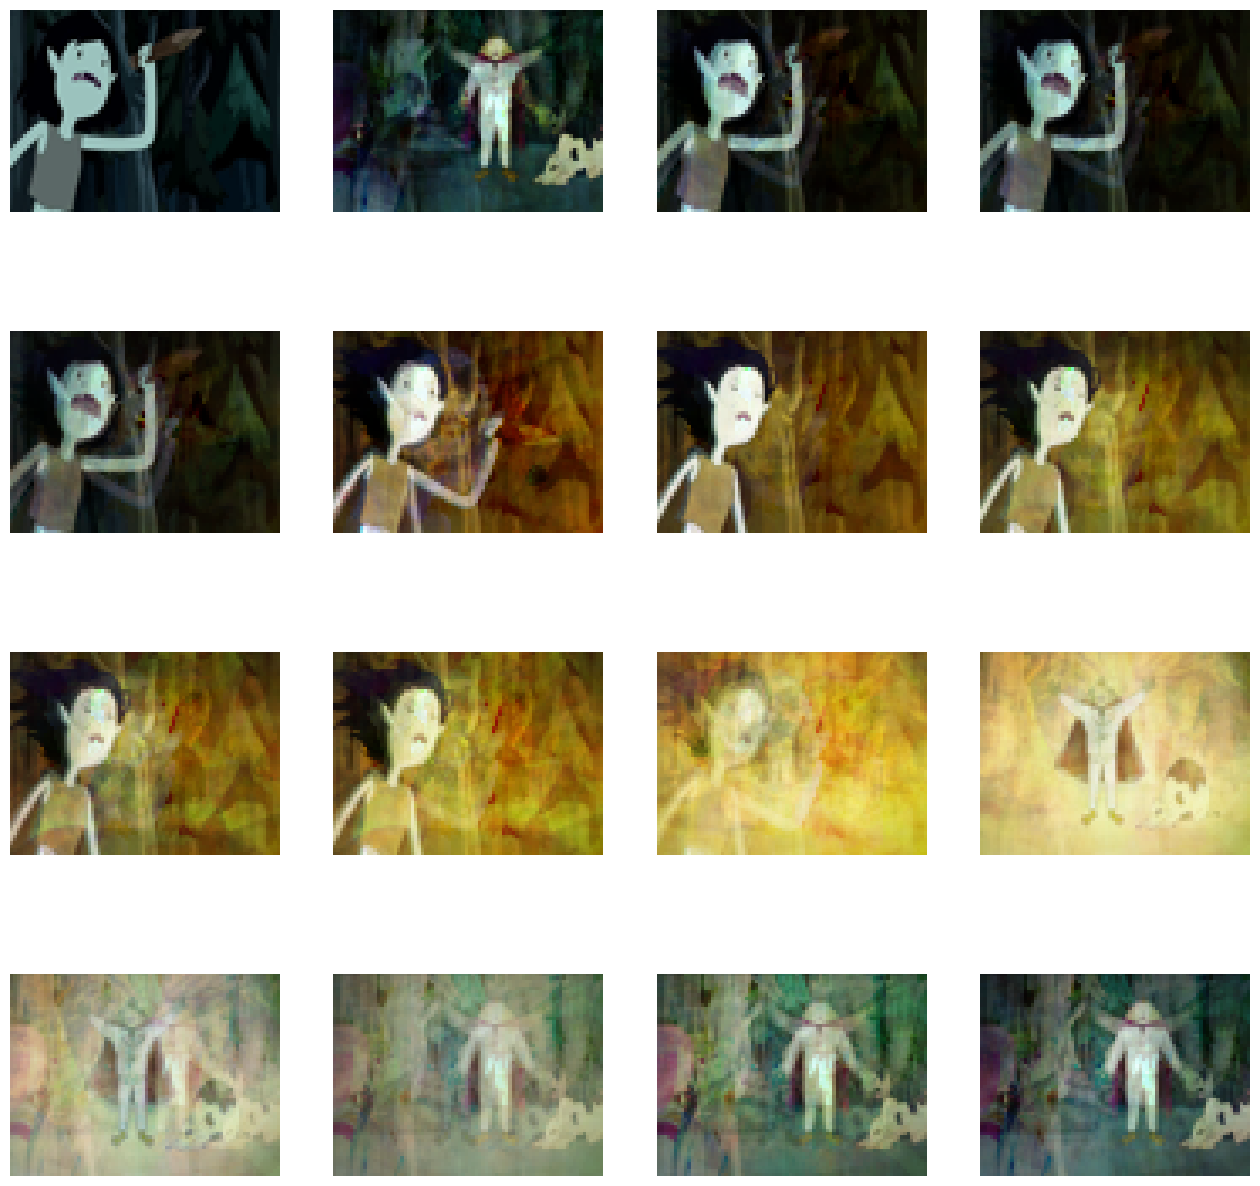

In [19]:
# And some images from training set

to_show = 100
sequence = X_sequence_train[to_show]

series = [X_sequence_train[to_show, 0]]

for i in range(16):
    next_frame = model.predict(np.expand_dims(sequence, axis = 0))

    sequence = np.concatenate((sequence[1:, :, :, :], next_frame), axis = 0)
    frame = next_frame[0]
    series.append(frame)

fig, axes = plt.subplots(4, 4, figsize = (16, 16))

for i in range(4):
    for j in range(4):
        axes[i, j].imshow(series[i * 4 + j])
        axes[i, j].axis('off')

plt.show()


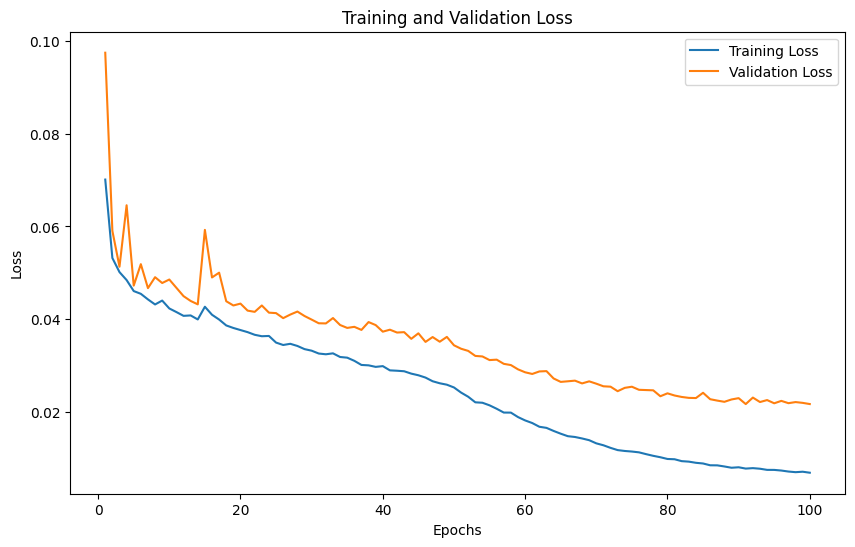

In [11]:
# And show training metric

train_loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize = (10, 6))
epochs = range(1, len(train_loss) + 1)
plt.plot(epochs, train_loss, label = 'Training Loss')
plt.plot(epochs, val_loss, label = 'Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()